In [1]:
import numpy as np
from scipy.fftpack import fft,ifft
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time


# 1. Option Pricing via FFT Techniques The Heston Model is defined by the following
system of stochastic dierential equations:

$\begin{aligned} d S_{t} &=r S_{t} d t+\sqrt{\nu_{t}} S_{t} d W_{t}^{1} \\ d \nu_{t} &=\kappa\left(\theta-\nu_{t}\right) d t+\sigma \sqrt{\nu_{t}} d W_{t}^{2} \\ \operatorname{Cov}\left(d W_{t}^{1}, d W_{t}^{2}\right) &=\rho d t \end{aligned}$

The characteristic function for the Heston Model is known to be:

$\begin{aligned} \omega(u) &=\frac{\exp \left(i u \ln S_{0}+i u(r-q) t+\frac{\kappa \theta t(\kappa-i \rho \sigma u)}{\sigma^{2}}\right)}{\left(\cosh \frac{\lambda t}{2}+\frac{\kappa-i \rho \sigma u}{\lambda} \sinh \frac{\lambda t}{2}\right)^{\frac{2 \kappa \theta}{\sigma^{2}}}} \\ \Phi(u) &=\omega(u) \exp \left(\frac{-\left(u^{2}+i u\right) \nu_{0}}{\lambda \operatorname{coth} \frac{\lambda t}{2}+\kappa-i \rho \sigma u}\right) \end{aligned}$

$\lambda=\sqrt{\sigma^{2}\left(u^{2}+i u\right)+(\kappa-i \rho \sigma u)^{2}}$

Assume the risk-free rate is 2%, the initial asset price is 250 and that the asset pays no
dividends.

(a) Exploring FFT Technique Parameters Consider a European Call Option with
strike 250 expiring in six months.
Additionally, assume you know that the parameters of the Heston Model are:

$\begin{aligned} \sigma &=0.2 \\ \nu_{0} &=0.08 \\ \kappa &=0.7 \\ \rho &=-0.4 \\ \theta &=0.1 \end{aligned}$

In [2]:
sigma = 0.2
v0 = 0.08
k= 0.7
rho = -0.4
theta = 0.1
r = 0.02
S0 = 250
q = 0

i. Calculate the price of the European Call option with many values for the damping
factor,$\alpha$. What values of $\alpha$ seem to lead to the most stable price?

In [3]:
def characteristic_function(u,t,sigma=0.2,v0=0.08,k=0.7,rho=-0.4,theta=0.1,r=0.02,S0=250,q=0):
    Lambda = np.sqrt((sigma ** 2) * (complex(u ** 2, u)) + (complex(k, -rho * sigma * u)) ** 2)
    omega = np.exp(complex(0, u * (np.log(S0) + (r - q) * t)) + k * theta * t * complex(k, -rho * sigma * u) / sigma ** 2) \
            / (np.cosh(Lambda * t / 2) + (complex(k, -rho * sigma * u) / Lambda) * np.sinh(Lambda * t / 2)) ** (2 * k * theta / sigma ** 2)
    phi = omega * np.exp(-(complex(u ** 2, u)) * v0 / (Lambda / np.tanh(Lambda * t / 2) + complex(k, -rho * sigma * u)))
    return phi

In [4]:
def fft(K=250,n=10,alpha=1,UB=500,t=0.5):

    N = 2 ** n
    B = UB
    
    v = np.linspace(0, B, N+1)[0:-1]
    delta_v = B / N
    
    delta_k = 2 * np.pi / B
    beta = np.log(S0) - delta_k * N / 2
    km = beta + (np.linspace(0, N, N+1)[0:-1]) * delta_k

    x = []
    for j in range(N):
        if j == 0:
            wj = 0.5
        else:
            wj = 1
        
        phi = characteristic_function(complex(v[j], -(alpha + 1)),t,sigma,v0,k,rho,theta,r,S0,q)
        xj = phi * np.exp(complex(0, -beta) * v[j]) * wj * delta_v / \
             (complex(alpha, v[j])) / complex(alpha + 1, v[j])
        x.append(xj)
    x = np.array(x) * np.exp(-r * t)
    y = np.fft.fft(x)

    call_price = []
    for j in range(N):
        c = np.exp(-alpha * (np.log(S0) - delta_k * (N / 2 - j))) * np.real(y[j]) / np.pi
        call_price.append(c)
    return np.exp(km), call_price

In [5]:
def call_price(K=250,n=10,alpha=1,UB=600,t=0.5):
    K_list, price_list = fft(K,n,alpha,UB,t)
    return np.interp(K, K_list, price_list)

In [6]:
cp = call_price()

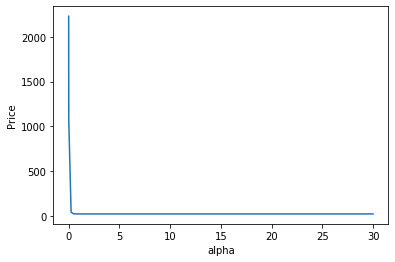

{0.01: 2229.8687999438275, 0.02: 1066.4147076281254, 0.25: 39.65471098486569, 0.5: 22.447661289815688, 0.8: 21.31589507022012, 1: 21.274373625509067, 1.05: 21.272088364540355, 1.5: 21.26889305392571, 1.75: 21.268868982409007, 10: 21.268867212072806, 30: 21.2688671747742}


In [7]:
alpha_list = [0.01,0.02,0.25,0.5,0.8,1,1.05,1.5,1.75,10,30]
c0_list = []
for i in alpha_list:
    c0_list.append(call_price(alpha=i))
plt.xlabel('alpha')
plt.ylabel('Price')
plt.plot(alpha_list, c0_list)
plt.show()
print(dict(zip(alpha_list,c0_list)))

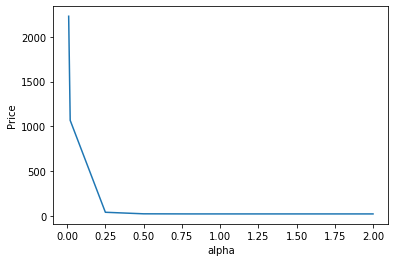

{0.01: 2229.8687999438275, 0.02: 1066.4147076281254, 0.25: 39.65471098486569, 0.5: 22.447661289815688, 0.8: 21.31589507022012, 1: 21.274373625509067, 1.05: 21.272088364540355, 1.5: 21.26889305392571, 1.75: 21.268868982409007, 2: 21.268867333352297}


In [8]:
alpha_list = [0.01,0.02,0.25,0.5,0.8,1,1.05,1.5,1.75,2]
c0_list = []
for i in alpha_list:
    c0_list.append(call_price(alpha=i))
plt.xlabel('alpha')
plt.ylabel('Price')
plt.plot(alpha_list, c0_list)
plt.show()

As shown above, $\alpha = 1$ seem to lead to the most stable price.

ii. Using the results above, choose a reasonable value of $\alpha$ and calculate the price of
the same European Call with various values of $N$ and $\Delta k$ (or equivalently N and
B). Comment on what values seem to lead to the most accurate prices, and the
efficiency of each parameterization.

According to 1.i, we choose $\alpha = 1$ which leads to a stablr price to calculate the price of
the same European Call with various values of $N$ and $\Delta k$ (or equivalently N and
B)

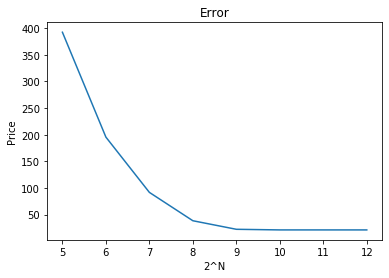

In [9]:
n_list = np.arange(5,13,1)
c0_list = []
for i in n_list:
    c0_list.append(call_price(alpha=1,n=i))
plt.title('Error')
plt.xlabel('2^N')
plt.ylabel('Price')
plt.plot(n_list, c0_list)

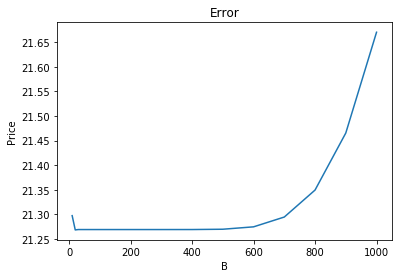

In [10]:
UB_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
c0_list = []
for i in UB_list:
    c0_list.append(call_price(UB=i))
plt.title('Error')
plt.xlabel('B')
plt.ylabel('Price')
plt.plot(UB_list, c0_list)

In [11]:
n_list = []
UB_list = []
error_list = []
runtime_list = []
for i in np.arange(10, 200, 10):
    for j in np.arange(9 ,12, 1):
        start = time.time()
        c = call_price(alpha=1, UB=i, n=j)
        over = time.time()
        if abs(c-cp) < 0.01:
            n_list.append(j)
            UB_list.append(i)
            error_list.append(abs(c-cp))
            runtime_list.append(np.float64(over - start))

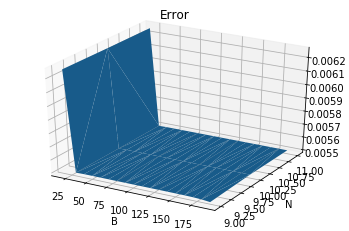

In [13]:
ax = plt.subplot(111, projection='3d')
plt.title('Error')
plt.xlabel('B')
plt.ylabel('N')
ax.plot_trisurf(UB_list,n_list,error_list)

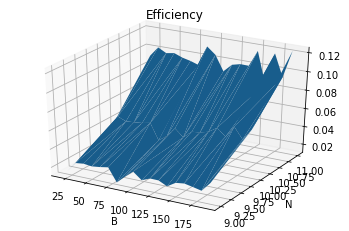

In [14]:
ax = plt.subplot(111, projection='3d')
plt.title('Efficiency')
plt.xlabel('B')
plt.ylabel('N')
ax.plot_trisurf(UB_list,n_list,runtime_list)

$N = 2^{9}, B = 160$ seem to lead to the most accurate prices under the consideration of the efficiency.

iii. Calculate the price of a European Call with strike 260 using various values of $N$
and $\Delta k$ (or $N$ and $B$). Do the same sets of values for $N$,$B$ and $\Delta k$ produce the
best results? Comment on any differences that arise.

In [15]:
cp = call_price(K=260)

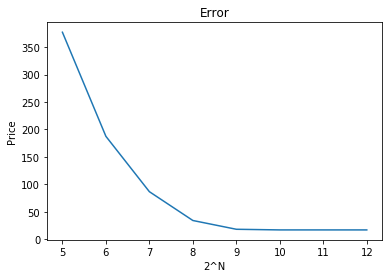

In [16]:
n_list = []
c0_list = []
for i in np.arange(5,13,1):
    n_list.append(i)
    c0_list.append(call_price(K=260,n=i))
plt.title('Error')
plt.xlabel('2^N')
plt.ylabel('Price')
plt.plot(n_list, c0_list)

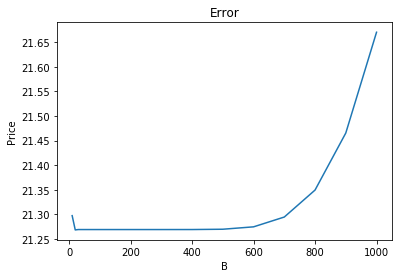

In [17]:
UB_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
c0_list = []
for i in UB_list:
    c0_list.append(call_price(UB=i))
plt.title('Error')
plt.xlabel('B')
plt.ylabel('Price')
plt.plot(UB_list, c0_list)

In [18]:
n_list = []
UB_list = []
error_list = []
runtime_list = []
for i in np.arange(10, 200, 10):
    for j in np.arange(9 ,12, 1):
        start = time.time()
        c = call_price(K=260,alpha=1, UB=i, n=j)
        over = time.time()
        if abs(c-cp) < 0.05:
            n_list.append(j)
            UB_list.append(i)
            error_list.append(abs(c-cp))
            runtime_list.append(np.float64(over - start))

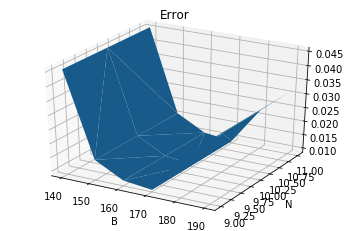

In [19]:
ax = plt.subplot(111, projection='3d')
plt.title('Error')
plt.xlabel('B')
plt.ylabel('N')
ax.plot_trisurf(UB_list,n_list,error_list)

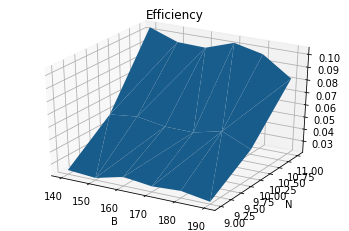

In [20]:
ax = plt.subplot(111, projection='3d')
plt.title('Efficiency')
plt.xlabel('B')
plt.ylabel('N')
ax.plot_trisurf(UB_list,n_list,runtime_list)

Given a European Call with strike 260, $N = 2^{9}, B = 170$ seem to lead to the most accurate prices, under the consideration of the efficiency.

(b) Exploring Heston Parameters Assume the risk-free rate is 2.5%, the initial asset
price is 150 and that the asset pays no dividends.

$\begin{aligned} \sigma &=0.4 \\ \nu_{0} &=0.09 \\ \kappa &=0.5 \\ \rho &=0.25 \\ \theta &=0.12 \end{aligned}$

In [21]:
sigma = 0.4
v0 = 0.09
k = 0.5
rho = 0.25
theta = 0.12
r = 0.025
S0 = 150
q = 0

i. Using these parameters, calculate Heston Model prices for three-month options
at a range of strikes and extract the implied volatilities for each strike. Plot the
implied volatility $\sigma (K)$ as a function of strike.

In [22]:
def bsm_call_value(s0, k, t, r, sigma):
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = (np.log(s0 / k) + (r - 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    value = (s0 * stats.norm.cdf(d1) - k * np.exp(-r * t) * stats.norm.cdf(d2))
    # print('cvalue',value)
    return value

In [23]:
def impliedvol_to_K(n=10,alpha=1,UB=600,t=0.25):
    K_list = np.linspace(80,230,60)
    c0_list = []
    strike_list, price_list = fft(K=150,n=n,alpha=alpha,UB=UB,t=t)
    for k in K_list:
        c0 = np.interp(k, strike_list, price_list)
        c0_list.append(c0)
    #plt.plot(K_list, c0_list)
    vol_list = []
    for i in np.arange(0,len(K_list),1):
        vol_list.append(fsolve(lambda x: bsm_call_value(150, K_list[i], 0.25, 0.025, x)-c0_list[i],x0=0.5))
    return np.array(K_list),np.array(vol_list)

In [24]:
def impliedvol_to_T(K=150,n=10,alpha=1,UB=600,t=0.25):
    t_list = np.arange(0.1,2,0.1)
    c0_list = []
    for ti in t_list:
        c0_list.append(call_price(K=K,n=n,alpha=alpha,UB=UB,t=ti))
    #plt.plot(t_list, c0_list)
    vol_list = []
    for i in np.arange(0,len(t_list),1):
        vol_list.append(fsolve(lambda x: bsm_call_value(150, 150, t_list[i], 0.025, x)-c0_list[i],x0=0.5))
    return np.array(t_list),np.array(vol_list)

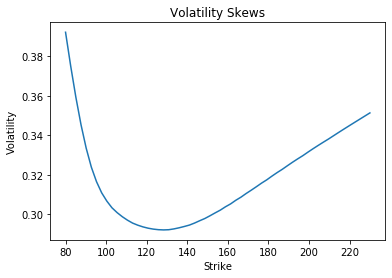

In [27]:
Strike,Vol_K = impliedvol_to_K()
plt.title('Volatility Skews')
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.plot(Strike,Vol_K)

ii. Use the FFT pricing technique to obtain prices of 150 strike calls at many expiries.
Extract the implied volatility for each and plot the term structure of volatility by
plotting time to expiry on the x-axis and implied volatility on the y-axis.

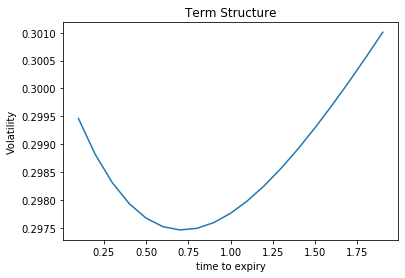

In [29]:
tlist, Vol_T = impliedvol_to_T()
plt.title('Term Structure')
plt.xlabel('time to expiry')
plt.ylabel('Volatility')
plt.plot(tlist,Vol_T)

iii. Holding all other parameters constant, vary each of the model parameters and plot
the updated volatility skews and term structures. Comment on the impact that
each parameter has on the skew and term structure.

Change $\sigma$

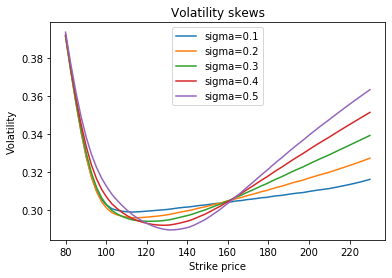

In [30]:
sigma = 0.4
sigma_list = np.arange(-0.3,0.2,0.1) + sigma
strike_list = []
vol_list = []
i = 0
for si in sigma_list:
    sigma = si
    strike,Vol = impliedvol_to_K()
    strike_list.append(strike)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Volatility skews')
plt.xlabel('Strike price')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(strike_list[j], vol_list[j],label='sigma='+ str(round(sigma_list[j],2)) +'')
plt.legend()
plt.show()

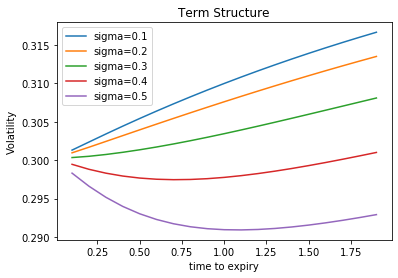

In [31]:
sigma = 0.4
sigma_list = np.arange(-0.3,0.2,0.1) + sigma
t_list = []
vol_list = []
i = 0
for si in sigma_list:
    sigma = si
    ti,Vol = impliedvol_to_T()
    t_list.append(ti)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Term Structure')
plt.xlabel('time to expiry')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(t_list[j], vol_list[j],label='sigma='+ str(round(sigma_list[j],2)) +'')
plt.legend()
plt.show()

Increase of $\sigma$ sharpen the volatility skews but may switch the term structures from a increasing function to a decreasing one

Change $\nu_{0}$

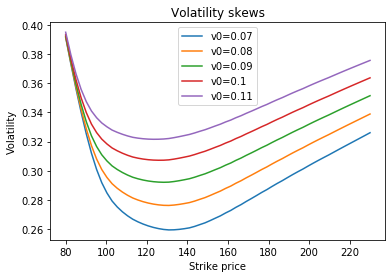

In [32]:
sigma = 0.4
v0 = 0.09
v0_list = np.arange(-0.02,0.03,0.01) + v0
strike_list = []
vol_list = []
i = 0
for v0i in v0_list:
    v0 = v0i
    strike,Vol = impliedvol_to_K()
    strike_list.append(strike)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Volatility skews')
plt.xlabel('Strike price')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(strike_list[j], vol_list[j],label='v0='+ str(round(v0_list[j],2)) +'')
plt.legend()
plt.show()

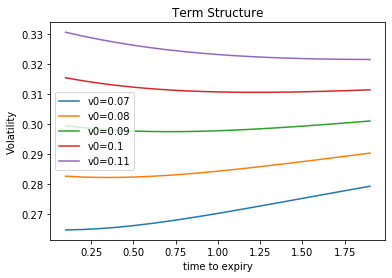

In [33]:
sigma = 0.4
v0 = 0.09
v0_list = np.arange(-0.02,0.03,0.01) + v0
t_list = []
vol_list = []
i = 0
for v0i in v0_list:
    v0 = v0i
    ti,Vol = impliedvol_to_T()
    t_list.append(ti)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Term Structure')
plt.xlabel('time to expiry')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(t_list[j], vol_list[j],label='v0='+ str(round(v0_list[j],2)) +'')
plt.legend()
plt.show()

The decrease of $\nu_{0}$ lead to sharper volatility skews and the term structures seem to switch from decreasing function to a incresaing one with a low level of volatility.

Change $k$

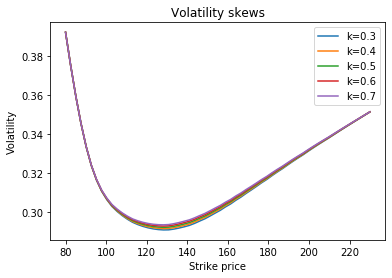

In [34]:
sigma = 0.4
v0 = 0.09
k = 0.5
k_list = np.arange(-0.2,0.3,0.1) + k
strike_list = []
vol_list = []
i = 0
for ki in k_list:
    k = ki
    strike,Vol = impliedvol_to_K()
    strike_list.append(strike)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Volatility skews')
plt.xlabel('Strike price')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(strike_list[j], vol_list[j],label='k='+ str(round(k_list[j],2)) +'')
plt.legend()
plt.show()

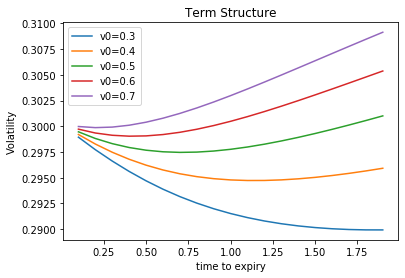

In [35]:
sigma = 0.4
v0 = 0.09
k = 0.5
k_list = np.arange(-0.2,0.3,0.1) + k
t_list = []
vol_list = []
i = 0
for ki in k_list:
    k = ki
    ti,Vol = impliedvol_to_T()
    t_list.append(ti)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Term Structure')
plt.xlabel('time to expiry')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(t_list[j], vol_list[j],label='v0='+ str(round(k_list[j],2)) +'')
plt.legend()
plt.show()

Change of $k$ seem not to affect volatility skews, however increase of $k$ may switch term structures from a decreasing function to a increasing one.

Change $\rho$

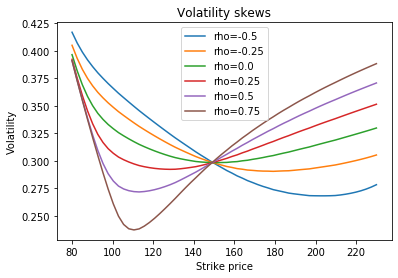

In [36]:
sigma = 0.4
v0 = 0.09
k = 0.5
rho = 0.25
rho_list = np.arange(-0.75,0.75,0.25) + rho
vol_list = []
i = 0
for rhoi in rho_list:
    rho = rhoi
    strike,Vol = impliedvol_to_K()
    strike_list.append(strike)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Volatility skews')
plt.xlabel('Strike price')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(strike_list[j], vol_list[j],label='rho='+ str(round(rho_list[j],2)) +'')
plt.legend()
plt.show()

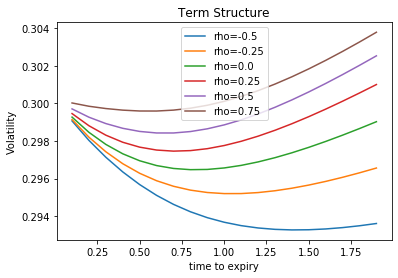

In [37]:
sigma = 0.4
v0 = 0.09
k = 0.5
rho = 0.25
rho_list = np.arange(-0.75,0.75,0.25) + rho
t_list = []
vol_list = []
i = 0
for rhoi in rho_list:
    rho = rhoi
    ti,Vol = impliedvol_to_T()
    t_list.append(ti)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Term Structure')
plt.xlabel('time to expiry')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(t_list[j], vol_list[j],label='rho='+ str(round(rho_list[j],2)) +'')
plt.legend()
plt.show()

Increase of absolute value of $\rho$ result in sharper volatility skews, increase of $\rho$ may switch term structures from a decreasing function to a increasing one.

Change $\theta$

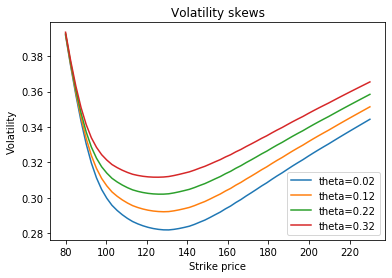

In [38]:
sigma = 0.4
v0 = 0.09
k = 0.5
rho = 0.25
theta = 0.12
theta_list = np.arange(-0.1,0.2,0.1) + theta
t_list = []
vol_list = []
i = 0
for thetai in theta_list:
    theta = thetai
    strike,Vol = impliedvol_to_K()
    strike_list.append(strike)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Volatility skews')
plt.xlabel('Strike price')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(strike_list[j], vol_list[j],label='theta='+ str(round(theta_list[j],2)) +'')
plt.legend()
plt.show()

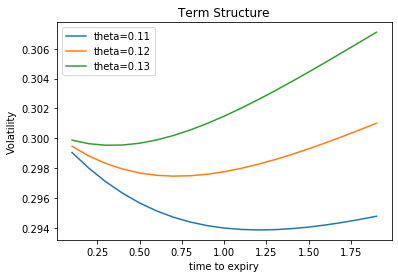

In [39]:
sigma = 0.4
v0 = 0.09
k = 0.5
rho = 0.25
theta = 0.12
theta_list = np.arange(-0.01,0.02,0.01) + theta
t_list = []
vol_list = []
i = 0
for thetai in theta_list:
    theta = thetai
    ti,Vol = impliedvol_to_T()
    t_list.append(ti)
    vol_list.append(Vol)
l = len(vol_list)
plt.title('Term Structure')
plt.xlabel('time to expiry')
plt.ylabel('Volatility')
for j in np.arange(0,l,1):
    plt.plot(t_list[j], vol_list[j],label='theta='+ str(round(theta_list[j],2)) +'')
plt.legend()
plt.show()

Decrease of $\theta$ result in sharper volatility skews, increase of $\theta$ may switch term structures from a decreasing function to a increasing one.